# Predicting Salary

Carlos Adrian Alarcon

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Initial transformation

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
from sklearn.naive_bayes import MultinomialNB
from utils.functions import *
import os
import warnings
import re
warnings.filterwarnings("ignore")


In [6]:
## Reading data
data = pd.read_csv('data/Train_rev1.csv')

In [7]:
## Sampling according to the requirement

df = data.sample(2500, random_state=123)

In [8]:
## Splitting data into train and test
x = df[['FullDescription']]
y = df['SalaryNormalized']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

In [9]:
## Generating target variable using training variable

p75 = y_train.quantile(0.75)
y_train_cat = np.where(y_train > p75, 1, 0)
y_test_cat = np.where(y_test > p75, 1, 0)


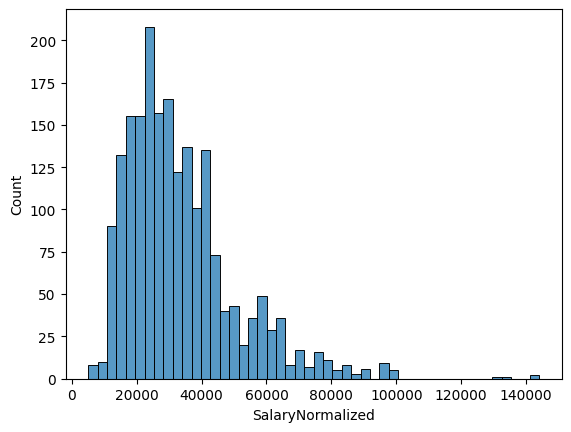

In [10]:
## Analyzing target variable

sns.histplot(x = y_train)
plt.show()

## Data preprocessing

In [11]:
x_train['cleaned_description'] = x_train['FullDescription'].apply(lambda x: clean_data(x))
x_test['cleaned_description'] = x_test['FullDescription'].apply(lambda x: clean_data(x))

In [12]:
## Tokenizing the data

regexp = RegexpTokenizer('\w+')
x_train['cleaned_description_token'] = x_train['cleaned_description'].apply(lambda x: regexp.tokenize(x))
x_test['cleaned_description_token'] = x_test['cleaned_description'].apply(lambda x: regexp.tokenize(x))

In [13]:
## Remove stop words

stopwords = nltk.corpus.stopwords.words("english")

## Add custom stop words

my_stopwords = ['https','www']
stopwords.extend(my_stopwords)

x_train['cleaned_description_token'] = x_train['cleaned_description_token'].apply(lambda x: [word for word in x if word.lower() not in stopwords])
x_test['cleaned_description_token'] = x_test['cleaned_description_token'].apply(lambda x: [word for word in x if word.lower() not in stopwords])

In [14]:
## Lemmatization
wordnet_lem = WordNetLemmatizer()
x_train['cleaned_description_token'] = x_train['cleaned_description_token'].apply(lambda x: [wordnet_lem.lemmatize(word) for word in x])
x_test['cleaned_description_token'] = x_test['cleaned_description_token'].apply(lambda x: [wordnet_lem.lemmatize(word) for word in x])

In [15]:
## Joining the words

x_train['final_description'] = x_train['cleaned_description_token'].apply(lambda x: ' '.join(x))
x_test['final_description'] = x_test['cleaned_description_token'].apply(lambda x: ' '.join(x))  

In [16]:
## Vectorizing the data

vect = CountVectorizer(stop_words='english',  ngram_range=(2,6))
x_train_vect = vect.fit_transform(x_train['final_description'])
x_test_vect = vect.transform(x_test['final_description'])

## Modelling

In [17]:
model_nb = MultinomialNB()
model_nb.fit(x_train_vect, y_train_cat)

MultinomialNB()

In [18]:
preds = model_nb.predict(x_test_vect)
proba = model_nb.predict_proba(x_test_vect)

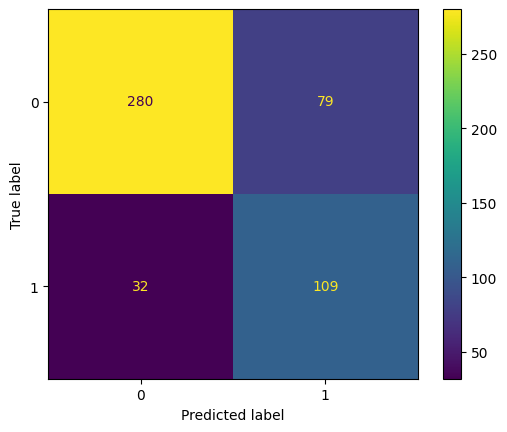

In [34]:
metrics, cm = get_metrics(preds, proba, y_test_cat, True)

In [20]:
metrics

{'accuracy': 0.786,
 'sensitivity': 0.3120567375886525,
 'specificity': 0.9721448467966574,
 'auc': 0.778758964025366}

## Optimizing parameters

In [21]:
model_nb = MultinomialNB()

min_range = [1,2,3,4,5,6,7,8,9,10]
max_range = [1,2,3,4,5,6,7,8,9,10]

In [22]:
list_auc = []
combinations = []
for i in max_range:
    for j in min_range:
        if j > i:
            continue
        else:
            auc = main_process(j, i, x_train, x_test, y_train_cat, y_test_cat, model_nb)
            print(auc)
            combination = (i,j)
            combinations.append(combination)
            list_auc.append(auc)
            

0.8256385942037574
0.796074596495387
0.815652225448942
0.7662537782255675
0.8050929492878168
0.7655425828246311
0.7528003318911871
0.7944447737015744
0.7444437859301843
0.6707856733637567
0.7454908236037852
0.7862265157351983
0.7338548766273534
0.6621525514135007
0.6185424445366363
0.7399000375353129
0.778758964025366
0.7279282482862166
0.6579940338608032
0.618473300539323
0.5956360259981429
0.7363440605306307
0.7731879333846974
0.7241944724313005
0.6569766293289081
0.6203105553250756
0.5953100614393804
0.5907959461862147
0.7337560994883343
0.7685256524230033
0.7225350164957822
0.6535885734605582
0.6152432880934036
0.5946877654635612
0.5903316936328257
0.5876054445959027
0.7313064264406646
0.7652264959797704
0.720776783421245
0.6514747426855529
0.6137715087220214
0.5943025346213873
0.5947173986052667
0.5920899267073628
0.5927912443943975
0.7291135739544441
0.7628558446433158
0.7197692566032516
0.6486200833679053
0.6134554218771607
0.5985697070270056
0.5944013117604061
0.592070171279559

In [23]:
print('Best combination:',combinations[np.argmax(list_auc)])

Best combination: (1, 1)


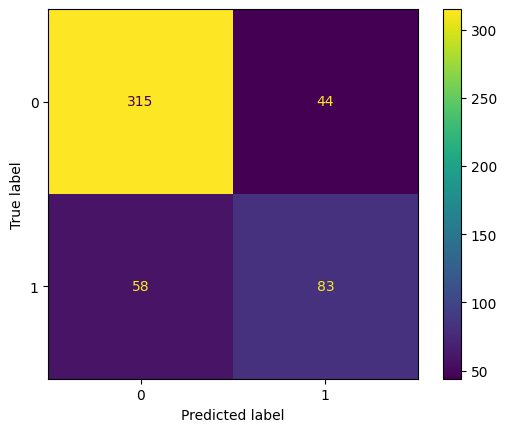

{'accuracy': 0.796, 'sensitivity': 0.5886524822695035, 'specificity': 0.8774373259052924, 'auc': 0.8256385942037574}


In [24]:
final_model = MultinomialNB()
x_train_esc, x_test_esc, _  = vectorizing(1,1,x_train, x_test)
final_model = training(final_model, x_train_esc, y_train_cat)
preds, proba = predict(final_model, x_test_esc)
metrics,_ = get_metrics(preds, proba, y_test_cat, True)
print(metrics)

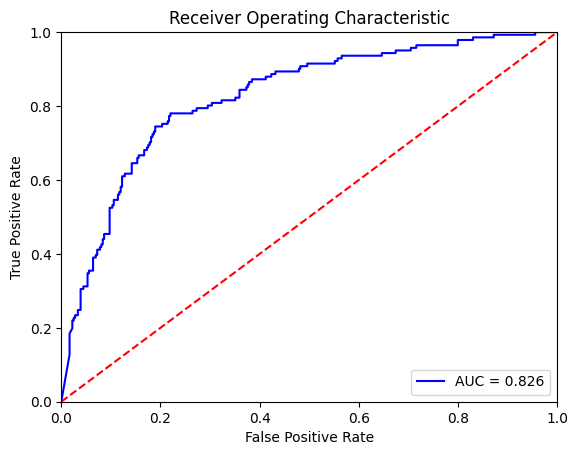

In [25]:
plot_roc_auc(y_test_cat, proba)

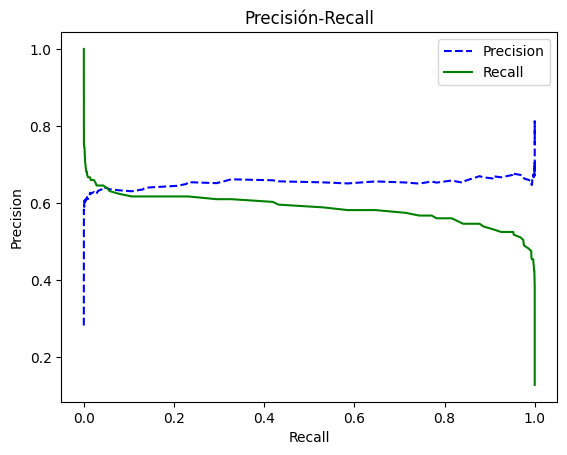

In [26]:
precision, recall, threshold = plot_precision_recall(y_test_cat, proba)

In [27]:
## Optimizing threshold using Youden index
final_threshold = threshold[np.argmax(recall + precision-1)]

## Final model

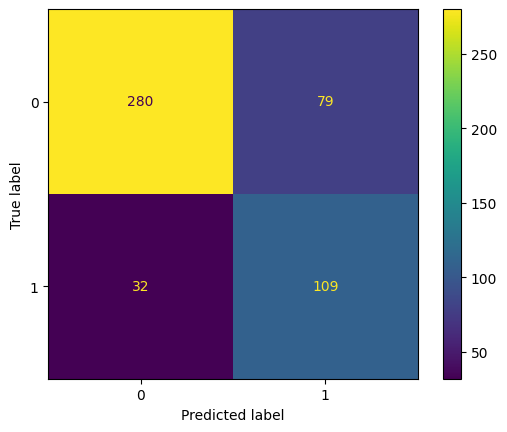

{'accuracy': 0.778,
 'sensitivity': 0.7730496453900709,
 'specificity': 0.7799442896935933,
 'auc': 0.8256385942037574}

In [28]:
final_model_w_optimized_threshold = MultinomialNB()
x_train_esc, x_test_esc, vect = vectorizing(1,1,x_train, x_test)
final_model_w_optimized_threshold = training(final_model_w_optimized_threshold, x_train_esc, y_train_cat)
preds, proba = predict(final_model, x_test_esc)

preds = np.where(proba[:,1] > final_threshold, 1, 0)
metrics,_ = get_metrics(preds, proba, y_test_cat, True)
metrics

## Interpreting results

In [29]:
prob_pos = sum(np.where(y_train_cat == 1 ,1,0))/len(y_train_cat)
prob_neg = sum(np.where(y_train_cat == 0 ,1,0))/len(y_train_cat)

In [30]:
df_nbf = pd.DataFrame()
df_nbf.index = vect.get_feature_names_out()
# Convert log probabilities to probabilities. 
df_nbf['pos'] = np.e**(final_model_w_optimized_threshold.feature_log_prob_[0, :])
df_nbf['neg'] = np.e**(final_model_w_optimized_threshold.feature_log_prob_[1, :])

 
df_nbf['odds_positive'] = (df_nbf['pos']/df_nbf['neg'])*(prob_pos /prob_neg)

df_nbf['odds_negative'] = (df_nbf['neg']/df_nbf['pos'])*(prob_neg/prob_pos )

In [31]:
odds_pos_top10 = df_nbf.sort_values('odds_positive',ascending=False)['odds_positive'][:10]
odds_neg_top10 = df_nbf.sort_values('odds_negative',ascending=False)['odds_negative'][:10]



In [32]:
odds_pos_top10

partie       10.220754
sou           9.357028
kitchen       9.213074
nvq           8.061440
cnc           7.773531
dealer        7.485623
assistant     7.428041
asbestos      6.549920
machine       6.549920
entry         6.477943
Name: odds_positive, dtype: float64

In [33]:
odds_neg_top10

aig           97.253099
strategist    97.253099
irish         76.413149
equity        71.782049
saas          69.466499
prism         69.466499
jm            69.466499
vsphere       69.466499
algorithm     69.466499
carillion     69.466499
Name: odds_negative, dtype: float64